<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session7/Session7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR

## Helper Methods

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [30]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 1024
epochs = 15
lr = 1e-3

Random seed set as 42
cuda


In [6]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [7]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

## DataPrep

Basic train test dataprep without much changes

In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])


In [9]:
# downloading train and test data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [10]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 1, 28, 28])
torch.Size([128])


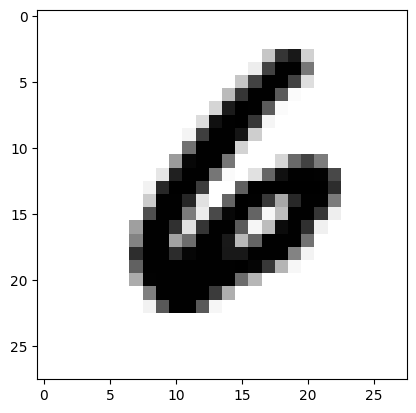

In [19]:
## Basic Data Statistics
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


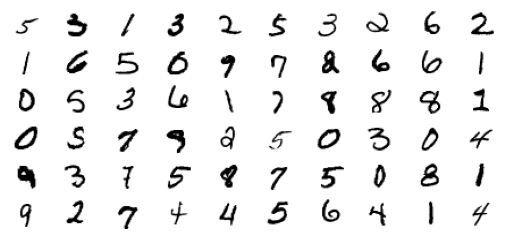

In [20]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Basic Cnn Classification Model

A few layers of Convolution with Batch Normalization and transition layer with (1,1) consolidator layer and maxpooling between 2 sets of conviolutuion layers

In [31]:
class Mnist_Baseline(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #7,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=7, stride=1, padding=0)) # 7*7 kernel as classifier


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [32]:
# New Model Instance
baseline_model = Mnist_Baseline(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(baseline_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             910
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
           Conv2d-10           [-1, 10, 22, 22]             110
      BatchNorm2d-11           [-1, 10, 22, 22]              20
             ReLU-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 1

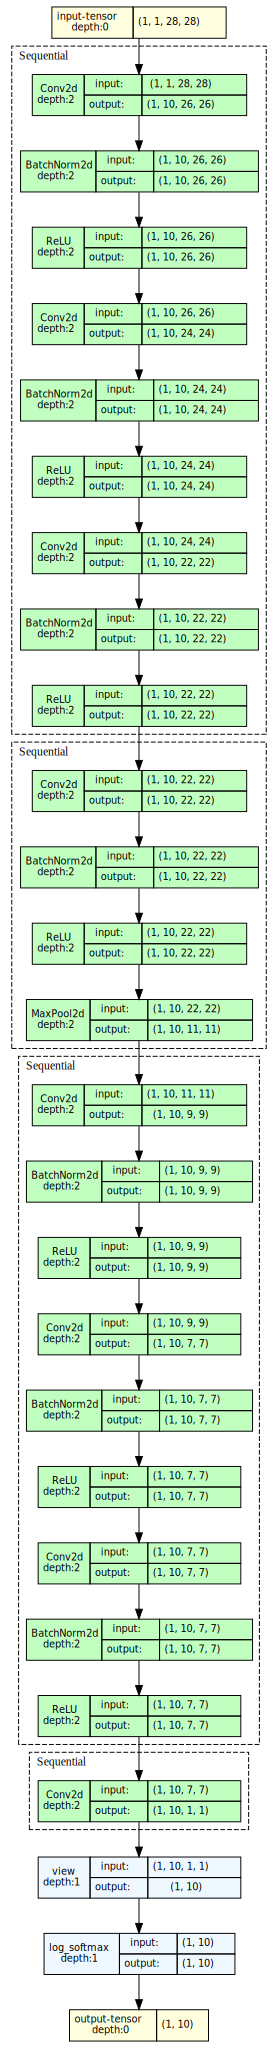

In [33]:
# graphical representation of the model architecture
model_graph = draw_graph(baseline_model, input_size=(1,1, 28, 28), expand_nested=True)
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [34]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [35]:
# updated testing modules---
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [36]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [37]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.25226563037331423 Avg Train Metric: 0.8374954014222251: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]


Function Took 24.6727 seconds


Avg Test Loss: 0.0631502170492954 Avg Test Metric: 0.9813330573371694: 100%|██████████| 79/79 [00:03<00:00, 25.97it/s]


Function Took 3.0520 seconds
Epoch 1


Avg Train Loss: 0.05960463008670601 Avg Train Metric: 0.9808718161796456: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]


Function Took 25.5683 seconds


Avg Test Loss: 0.04718238328689638 Avg Test Metric: 0.9853686811048773: 100%|██████████| 79/79 [00:03<00:00, 26.23it/s]


Function Took 3.0188 seconds
Epoch 2


Avg Train Loss: 0.04406493315363982 Avg Train Metric: 0.9864187207557499: 100%|██████████| 469/469 [00:24<00:00, 19.45it/s]


Function Took 24.1215 seconds


Avg Test Loss: 0.036603952887692026 Avg Test Metric: 0.987190414078628: 100%|██████████| 79/79 [00:02<00:00, 31.95it/s]


Function Took 2.4812 seconds
Epoch 3


Avg Train Loss: 0.03485566936135451 Avg Train Metric: 0.9888042300494749: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]


Function Took 22.8600 seconds


Avg Test Loss: 0.033902585385603055 Avg Test Metric: 0.9892761956287336: 100%|██████████| 79/79 [00:04<00:00, 17.63it/s]


Function Took 4.5012 seconds
Epoch 4


Avg Train Loss: 0.031218855616215593 Avg Train Metric: 0.9906824205730007: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s]


Function Took 25.6229 seconds


Avg Test Loss: 0.034285808783731886 Avg Test Metric: 0.9872727552546731: 100%|██████████| 79/79 [00:04<00:00, 19.53it/s]


Function Took 4.0600 seconds
Epoch 5


Avg Train Loss: 0.026723925668154475 Avg Train Metric: 0.9916642373050454: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]


Function Took 24.4216 seconds


Avg Test Loss: 0.036644137488041496 Avg Test Metric: 0.987217314635651: 100%|██████████| 79/79 [00:03<00:00, 22.69it/s]


Function Took 3.4924 seconds
Epoch 6


Avg Train Loss: 0.02303648055610515 Avg Train Metric: 0.9929554570458337: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]


Function Took 22.2000 seconds


Avg Test Loss: 0.03062257902767462 Avg Test Metric: 0.9907639569874052: 100%|██████████| 79/79 [00:04<00:00, 17.36it/s]


Function Took 4.5634 seconds
Epoch 7


Avg Train Loss: 0.021936112241859217 Avg Train Metric: 0.9936675752149716: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]


Function Took 20.6241 seconds


Avg Test Loss: 0.029773978392307682 Avg Test Metric: 0.989346778090996: 100%|██████████| 79/79 [00:02<00:00, 31.92it/s]


Function Took 2.4838 seconds
Epoch 8


Avg Train Loss: 0.018292112313687547 Avg Train Metric: 0.9950789027630902: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]


Function Took 21.7792 seconds


Avg Test Loss: 0.029045072176399393 Avg Test Metric: 0.9901328464097614: 100%|██████████| 79/79 [00:02<00:00, 29.79it/s]


Function Took 2.6633 seconds
Epoch 9


Avg Train Loss: 0.01712965969937538 Avg Train Metric: 0.9950331711311584: 100%|██████████| 469/469 [00:19<00:00, 23.99it/s]


Function Took 19.5615 seconds


Avg Test Loss: 0.02932003078336792 Avg Test Metric: 0.9913877497745466: 100%|██████████| 79/79 [00:03<00:00, 22.75it/s]


Function Took 3.4826 seconds
Epoch 10


Avg Train Loss: 0.014906195408411708 Avg Train Metric: 0.9957679132662857: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]


Function Took 18.7990 seconds


Avg Test Loss: 0.03545944239425508 Avg Test Metric: 0.9901246051245098: 100%|██████████| 79/79 [00:02<00:00, 31.60it/s]


Function Took 2.5108 seconds
Epoch 11


Avg Train Loss: 0.014372680423796665 Avg Train Metric: 0.995674336642853: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


Function Took 21.2302 seconds


Avg Test Loss: 0.03111239872825674 Avg Test Metric: 0.9918796163571032: 100%|██████████| 79/79 [00:02<00:00, 32.65it/s]


Function Took 2.4271 seconds
Epoch 12


Avg Train Loss: 0.012871810631677092 Avg Train Metric: 0.9964633627232712: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]


Function Took 18.9732 seconds


Avg Test Loss: 0.04049307650214509 Avg Test Metric: 0.9882669720468642: 100%|██████████| 79/79 [00:02<00:00, 31.30it/s]


Function Took 2.5332 seconds
Epoch 13


Avg Train Loss: 0.013621717219058273 Avg Train Metric: 0.9961120523115211: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]


Function Took 20.5934 seconds


Avg Test Loss: 0.029968137443920337 Avg Test Metric: 0.9909309842918492: 100%|██████████| 79/79 [00:02<00:00, 32.67it/s]


Function Took 2.4262 seconds
Epoch 14


Avg Train Loss: 0.011541729587426127 Avg Train Metric: 0.9968405791691372: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]


Function Took 18.7231 seconds


Avg Test Loss: 0.030437108279571315 Avg Test Metric: 0.9918347657481327: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]

Function Took 3.3402 seconds


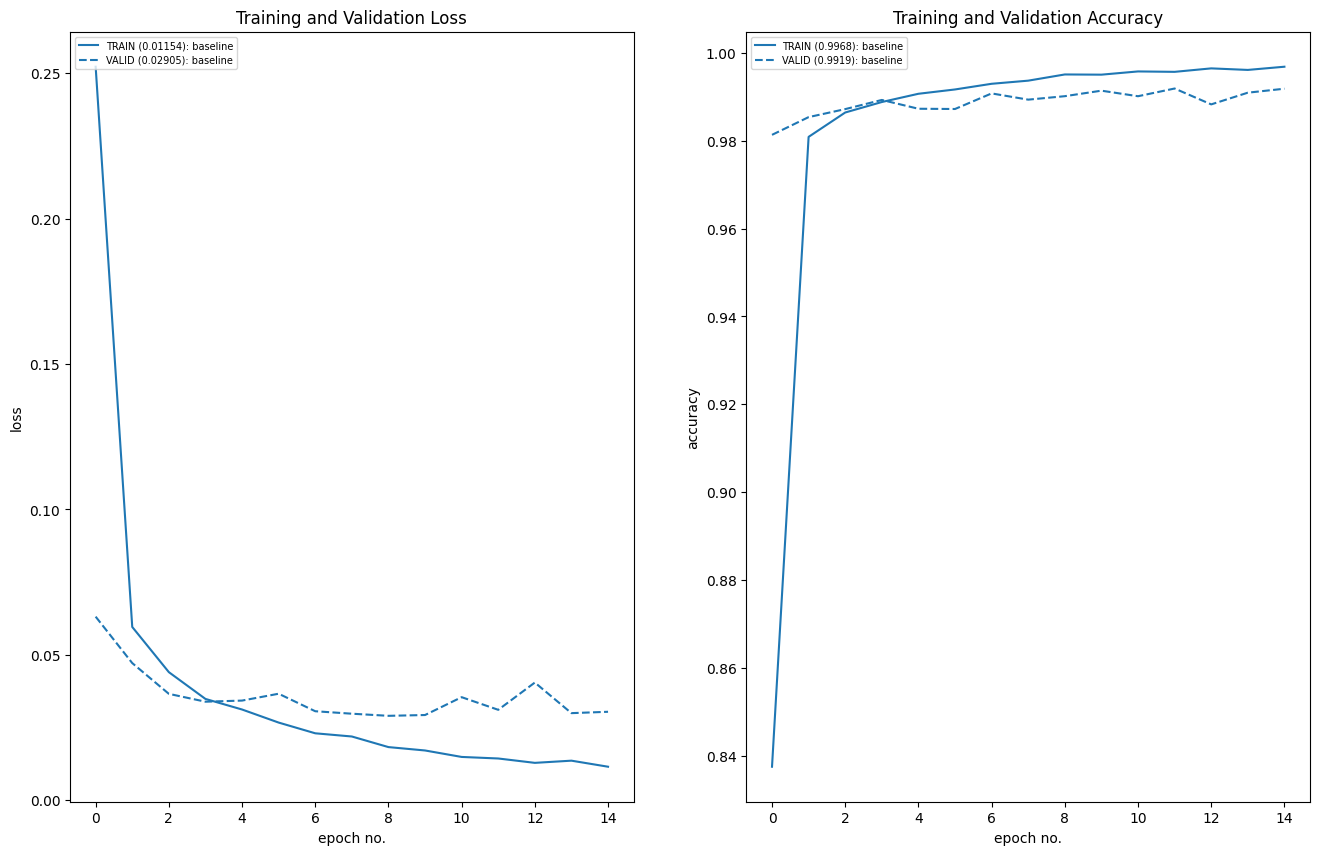

In [39]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:

1. Setting up the basic premise for model development
2. Baselin model with 2 sets of convolution blocks and 1 transition block
3. Application of only Batch normalization after every Cnn layer
4. Transition block applied after RF==7

Results:\
Parameters: 9k\
Best Training Accuracy: 99.68\
Best Test Accuracy: 99.19

Analysis:
1. As a Baseline model extremely effective with consistent results ie Accuracy>99
2. At times have founds extremely faint hints of overfitting but within allowable threshold

## Baseline Model -2

Expansion of second conv block with a layer and double kernels

In [71]:
class Mnist_Baseline2(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline2, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #5,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-4
        nn.Conv2d(in_channels=hidden_units , out_channels=(hidden_units * 2), kernel_size=3, stride=1, padding=0), #3,24
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=(hidden_units * 2), out_channels=out_channels, kernel_size=3, stride=1, padding=0)) # 3*3 kernel as classifier


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [72]:
# New Model Instance
baseline_model2 = Mnist_Baseline2(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(baseline_model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             910
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
           Conv2d-10           [-1, 10, 22, 22]             110
      BatchNorm2d-11           [-1, 10, 22, 22]              20
             ReLU-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 1

In [73]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [74]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model2, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.3283296484293651 Avg Train Metric: 0.7863691413580481: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]


Function Took 21.3825 seconds


Avg Test Loss: 0.06487018798914136 Avg Test Metric: 0.9788070668148089: 100%|██████████| 79/79 [00:02<00:00, 28.19it/s]


Function Took 2.8086 seconds
Epoch 1


Avg Train Loss: 0.059875789214608705 Avg Train Metric: 0.9817220249664046: 100%|██████████| 469/469 [00:24<00:00, 19.46it/s]


Function Took 24.1044 seconds


Avg Test Loss: 0.046841448396915876 Avg Test Metric: 0.9843425878995582: 100%|██████████| 79/79 [00:02<00:00, 27.36it/s]


Function Took 2.8983 seconds
Epoch 2


Avg Train Loss: 0.04499429662519299 Avg Train Metric: 0.9860925643937166: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]


Function Took 20.7662 seconds


Avg Test Loss: 0.034452831752810484 Avg Test Metric: 0.9899343697330619: 100%|██████████| 79/79 [00:03<00:00, 22.73it/s]


Function Took 3.4814 seconds
Epoch 3


Avg Train Loss: 0.037459129610085 Avg Train Metric: 0.9885944125494723: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]


Function Took 22.9551 seconds


Avg Test Loss: 0.035130200689493477 Avg Test Metric: 0.9882037865964672: 100%|██████████| 79/79 [00:03<00:00, 26.29it/s]


Function Took 3.0141 seconds
Epoch 4


Avg Train Loss: 0.03245497872131561 Avg Train Metric: 0.9889875194157111: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Function Took 20.2053 seconds


Avg Test Loss: 0.03109943007908856 Avg Test Metric: 0.9885343456570106: 100%|██████████| 79/79 [00:02<00:00, 32.52it/s]


Function Took 2.4382 seconds
Epoch 5


Avg Train Loss: 0.030803215677297907 Avg Train Metric: 0.9914320172277341: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]


Function Took 20.7271 seconds


Avg Test Loss: 0.027918703915975705 Avg Test Metric: 0.9896007353746439: 100%|██████████| 79/79 [00:02<00:00, 27.61it/s]


Function Took 2.8696 seconds
Epoch 6


Avg Train Loss: 0.027278921692503063 Avg Train Metric: 0.9923291942203986: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]


Function Took 19.4569 seconds


Avg Test Loss: 0.033773146160064806 Avg Test Metric: 0.99262250450593: 100%|██████████| 79/79 [00:02<00:00, 31.29it/s]


Function Took 2.5341 seconds
Epoch 7


Avg Train Loss: 0.024291769234659172 Avg Train Metric: 0.9925521678253532: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]


Function Took 20.9655 seconds


Avg Test Loss: 0.030015894872006735 Avg Test Metric: 0.9898539004446585: 100%|██████████| 79/79 [00:02<00:00, 27.59it/s]


Function Took 2.8762 seconds
Epoch 8


Avg Train Loss: 0.023082725076711795 Avg Train Metric: 0.9922851005088545: 100%|██████████| 469/469 [00:19<00:00, 23.91it/s]


Function Took 19.6255 seconds


Avg Test Loss: 0.02627077141958672 Avg Test Metric: 0.9894956372961213: 100%|██████████| 79/79 [00:03<00:00, 23.04it/s]


Function Took 3.4358 seconds
Epoch 9


Avg Train Loss: 0.02079704593902311 Avg Train Metric: 0.9937374720187075: 100%|██████████| 469/469 [00:19<00:00, 24.02it/s]


Function Took 19.5368 seconds


Avg Test Loss: 0.02747641440592942 Avg Test Metric: 0.9930141673812384: 100%|██████████| 79/79 [00:02<00:00, 32.45it/s]


Function Took 2.4426 seconds
Epoch 10


Avg Train Loss: 0.01910403080315375 Avg Train Metric: 0.994485310018698: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


Function Took 21.1255 seconds


Avg Test Loss: 0.026622549241207556 Avg Test Metric: 0.9915651294249522: 100%|██████████| 79/79 [00:02<00:00, 32.33it/s]


Function Took 2.4507 seconds
Epoch 11


Avg Train Loss: 0.018256911759335262 Avg Train Metric: 0.9946465931975765: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


Function Took 21.1055 seconds


Avg Test Loss: 0.031356753401246065 Avg Test Metric: 0.9903580350211904: 100%|██████████| 79/79 [00:02<00:00, 31.04it/s]


Function Took 2.5551 seconds
Epoch 12


Avg Train Loss: 0.01785831885866082 Avg Train Metric: 0.99491983321684: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]


Function Took 20.7297 seconds


Avg Test Loss: 0.028269393965631395 Avg Test Metric: 0.9886210100560249: 100%|██████████| 79/79 [00:02<00:00, 31.19it/s]


Function Took 2.5438 seconds
Epoch 13


Avg Train Loss: 0.015796726548806952 Avg Train Metric: 0.9957829567669297: 100%|██████████| 469/469 [00:19<00:00, 23.79it/s]


Function Took 19.7278 seconds


Avg Test Loss: 0.030337665843426637 Avg Test Metric: 0.9897764657117143: 100%|██████████| 79/79 [00:03<00:00, 22.41it/s]


Function Took 3.5317 seconds
Epoch 14


Avg Train Loss: 0.0151609531474679 Avg Train Metric: 0.9947716888588375: 100%|██████████| 469/469 [00:19<00:00, 24.10it/s]


Function Took 19.4665 seconds


Avg Test Loss: 0.03003818280714906 Avg Test Metric: 0.986554425728472: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]

Function Took 2.8230 seconds


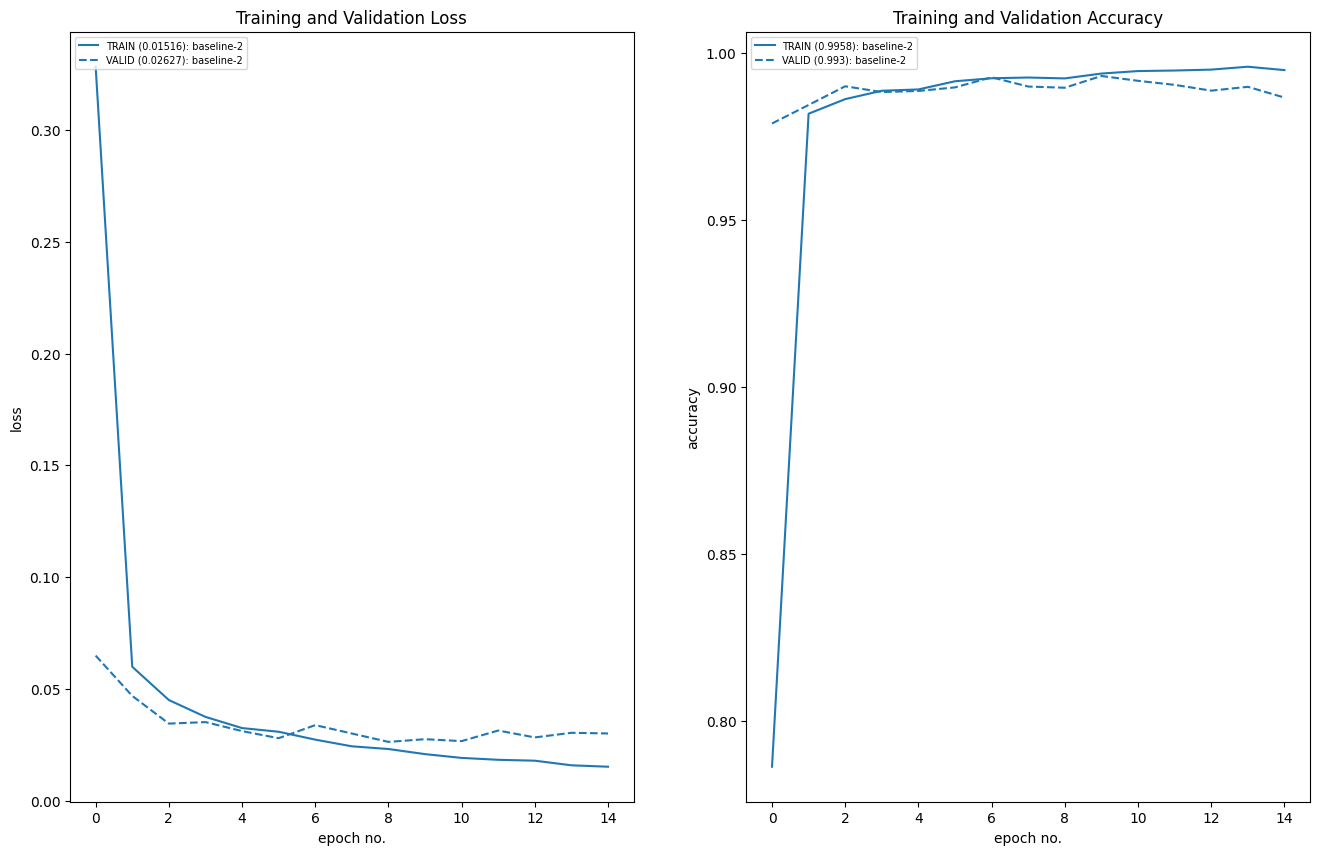

In [75]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-2'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Analysis:
1. Increasing channels/kernels in any layers leads to more overfitting and increased gap with increasing epochs

In [77]:
class Mnist_Baseline3(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline3, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #5,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-4
        nn.Conv2d(in_channels=hidden_units , out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #3,24
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=3, stride=1, padding=0)) # 3*3 kernel as classifier


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [78]:
# New Model Instance
baseline_model3 = Mnist_Baseline3(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(baseline_model3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
       BatchNorm2d-2           [-1, 20, 26, 26]              40
              ReLU-3           [-1, 20, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]           1,810
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             910
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
           Conv2d-10           [-1, 10, 22, 22]             110
      BatchNorm2d-11           [-1, 10, 22, 22]              20
             ReLU-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 2

In [79]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model3.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [80]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model3, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model3, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.4155198448994902 Avg Train Metric: 0.7544693607193574: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]


Function Took 21.3755 seconds


Avg Test Loss: 0.0938894151698185 Avg Test Metric: 0.9731635541855534: 100%|██████████| 79/79 [00:02<00:00, 31.60it/s]


Function Took 2.5080 seconds
Epoch 1


Avg Train Loss: 0.07352545297444502 Avg Train Metric: 0.9770787974664652: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]


Function Took 20.6716 seconds


Avg Test Loss: 0.05135074145561438 Avg Test Metric: 0.9853009053423435: 100%|██████████| 79/79 [00:02<00:00, 31.22it/s]


Function Took 2.5399 seconds
Epoch 2


Avg Train Loss: 0.05144185034919586 Avg Train Metric: 0.9837824547214549: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]


Function Took 20.7985 seconds


Avg Test Loss: 0.049110479782559446 Avg Test Metric: 0.9852526331249671: 100%|██████████| 79/79 [00:03<00:00, 24.34it/s]


Function Took 3.2540 seconds
Epoch 3


Avg Train Loss: 0.04300080965271096 Avg Train Metric: 0.9876549513355247: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]


Function Took 20.0628 seconds


Avg Test Loss: 0.04062618891696764 Avg Test Metric: 0.9876969849007039: 100%|██████████| 79/79 [00:02<00:00, 31.06it/s]


Function Took 2.5521 seconds
Epoch 4


Avg Train Loss: 0.03554780203114345 Avg Train Metric: 0.9890652827616694: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]


Function Took 21.1583 seconds


Avg Test Loss: 0.03627598661740747 Avg Test Metric: 0.9869487987288946: 100%|██████████| 79/79 [00:02<00:00, 30.36it/s]


Function Took 2.6110 seconds
Epoch 5


Avg Train Loss: 0.03227238002062432 Avg Train Metric: 0.9899777276937896: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]


Function Took 19.5646 seconds


Avg Test Loss: 0.037601126125082374 Avg Test Metric: 0.9887290770494486: 100%|██████████| 79/79 [00:02<00:00, 30.69it/s]


Function Took 2.5825 seconds
Epoch 6


Avg Train Loss: 0.02951240263455339 Avg Train Metric: 0.9920284683262107: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]


Function Took 20.7272 seconds


Avg Test Loss: 0.0387147956150525 Avg Test Metric: 0.9874381091021285: 100%|██████████| 79/79 [00:02<00:00, 31.87it/s]


Function Took 2.4879 seconds
Epoch 7


Avg Train Loss: 0.02744695156944721 Avg Train Metric: 0.9920985055630649: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]


Function Took 20.0815 seconds


Avg Test Loss: 0.03214274429645436 Avg Test Metric: 0.9892149099820777: 100%|██████████| 79/79 [00:03<00:00, 24.22it/s]


Function Took 3.2717 seconds
Epoch 8


Avg Train Loss: 0.024587248801253736 Avg Train Metric: 0.99321925767195: 100%|██████████| 469/469 [00:19<00:00, 24.02it/s]


Function Took 19.5322 seconds


Avg Test Loss: 0.03313845098998598 Avg Test Metric: 0.9897501853447926: 100%|██████████| 79/79 [00:02<00:00, 31.23it/s]


Function Took 2.5388 seconds
Epoch 9


Avg Train Loss: 0.022026948694354183 Avg Train Metric: 0.9939944394615922: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]


Function Took 21.3367 seconds


Avg Test Loss: 0.03300970912427653 Avg Test Metric: 0.9891893327990665: 100%|██████████| 79/79 [00:02<00:00, 32.04it/s]


Function Took 2.4741 seconds
Epoch 10


Avg Train Loss: 0.0223898977003515 Avg Train Metric: 0.9931400178083732: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]


Function Took 21.8102 seconds


Avg Test Loss: 0.03396070055933256 Avg Test Metric: 0.9904901800276358: 100%|██████████| 79/79 [00:02<00:00, 27.06it/s]


Function Took 2.9256 seconds
Epoch 11


Avg Train Loss: 0.020718405586429067 Avg Train Metric: 0.9937437610077197: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]


Function Took 19.7472 seconds


Avg Test Loss: 0.02971054510732146 Avg Test Metric: 0.9901982500583311: 100%|██████████| 79/79 [00:02<00:00, 32.22it/s]


Function Took 2.4638 seconds
Epoch 12


Avg Train Loss: 0.018354193549412093 Avg Train Metric: 0.9943607553744367: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]


Function Took 21.0018 seconds


Avg Test Loss: 0.03201844639067842 Avg Test Metric: 0.9881280200390876: 100%|██████████| 79/79 [00:02<00:00, 31.54it/s]


Function Took 2.5118 seconds
Epoch 13


Avg Train Loss: 0.01848863724987509 Avg Train Metric: 0.9943460796687649: 100%|██████████| 469/469 [00:19<00:00, 23.72it/s]


Function Took 19.7811 seconds


Avg Test Loss: 0.03789248480461538 Avg Test Metric: 0.9876126865797406: 100%|██████████| 79/79 [00:03<00:00, 22.21it/s]


Function Took 3.5661 seconds
Epoch 14


Avg Train Loss: 0.015811996578898178 Avg Train Metric: 0.9952849865213894: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]


Function Took 19.8961 seconds


Avg Test Loss: 0.027837983525617498 Avg Test Metric: 0.9909027580973468: 100%|██████████| 79/79 [00:02<00:00, 32.01it/s]

Function Took 2.4746 seconds


# Analysis:
1. Increasing channels/kernels in any layers leads to more overfitting and increased gap with increasing epochs